In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disneyland-reviews/DisneylandReviews.csv


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

# Upload the Dataset

In [3]:
df = pd.read_csv("/kaggle/input/disneyland-reviews/DisneylandReviews.csv",encoding='latin1')
print(df.shape)
df.head()

(42656, 6)


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


# Sorting according to rates

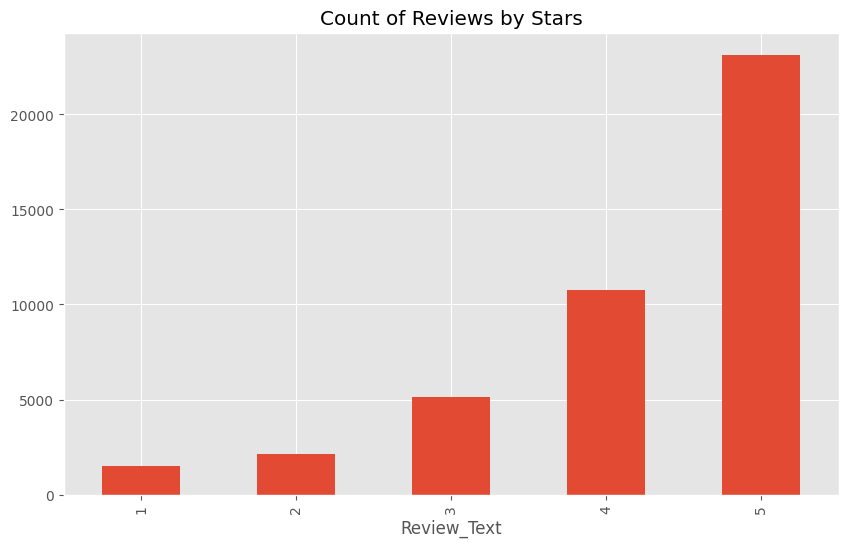

In [4]:
ax=df['Rating'].value_counts().sort_index() \
.plot(kind="bar",
       title ='Count of Reviews by Stars',
       figsize=(10,6))
ax.set_xlabel('Review_Text')
plt.show()

# Import Required Libraries

In [5]:
!pip uninstall transformers -y
!pip install transformers==4.32.1

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.

In [6]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [7]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
print("Model loaded Successfully")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model loaded Successfully


In [8]:
from tqdm import tqdm

In [9]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,   # truncate long texts
        max_length=512
    )
    output = model(**encoded_text)
    scores = softmax(output.logits[0].detach().numpy())
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

# Apply Sentimental Analysis on a Sample Dataset

In [10]:
sample_df = df.sample(n=10000, random_state=42).reset_index(drop=True)

In [11]:
res = {}
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    try:
        text = row['Review_Text']
        myid = row['Review_ID']
        res[myid] = polarity_scores_roberta(text)
    except Exception as e:
        print(f"Error for id {myid}: {e}")

100%|██████████| 10000/10000 [33:21<00:00,  5.00it/s]


# DataFrame of Result

In [12]:
result_table = pd.DataFrame(res).T
result_table = result_table.reset_index(drop=True)
result_table.index = result_table.index + 1

In [13]:
result_table

,roberta_neg,roberta_neu,roberta_pos
1,0.001605,0.008128,0.990267
2,0.717892,0.224429,0.057679
3,0.002274,0.013134,0.984592
4,0.001859,0.005528,0.992613
5,0.003488,0.034364,0.962148
...,...,...,...
9995,0.001986,0.008949,0.989065
9996,0.007248,0.042012,0.950740
9997,0.001161,0.009707,0.989132
9998,0.063954,0.295728,0.640318


# Calculating Accuracy 

In [14]:
min_len = min(len(df), len(result_table))
df = df.reset_index(drop=True).iloc[:min_len]
result_table = result_table.reset_index(drop=True).iloc[:min_len]


def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  
    elif rating == 3:
        return 1  
    else:
        return 2  

true_labels = df['Rating'].apply(rating_to_sentiment).values
predicted_labels = np.argmax(result_table[['roberta_neg','roberta_neu','roberta_pos']].values, axis=1)


from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)



Accuracy: 0.6752675267526753
